In [249]:
import numpy as np
import matplotlib.pyplot as plt
import math



In [250]:
noise = np.random.normal(0, 0.1, 10000)

class Performative_Regression:

    def __init__(self, nodes, sigma=1, n=1):

        self.k = len(nodes) - 1
        self.sigma = sigma
        self.M = 5*4**(len(nodes)-1)
        self.M = 1
        self.z = 1.96

        # Produce k+1 Chebyshev nodes
        #self.thetas = np.cos(np.pi * (2*np.arange(1, self.k+2) - 1 ) / (2*(self.k + 1)))
        self.nodes = nodes
        self.n = n

        # 
        #self.thetas = np.cos(np.pi * (2*np.arange(self.k+1) + 1 ) / (2*self.k + 2)) / np.cos(np.pi / (2*self.k + 2))
 
    def f(self, theta):
        
        #return theta**0 
        return -np.cos(0.2*theta) + 0.8*np.sin(5*(theta - 2)) + theta
  
    def observations(self, observation_nodes):
        
        k = len(observation_nodes)

        return self.f(observation_nodes) + noise[: k]
    
    def g_hat(self, theta):

        p_theta = 0
        for i in range(self.k+1):
            prod = 1
            for j in range(self.k+1):
                if j != i:
                    prod = prod * (theta - self.nodes[j]) / (self.nodes[i] - self.nodes[j])

            p_theta = p_theta + prod * self.observations(self.nodes)[i]
        
        return p_theta
    
    def conf_interval(self, theta):

        prod = 1 
        for i in range(self.k+1):
            prod = prod * (theta - self.nodes[i])

        lagrange_squared_sum = 0
        for i in range(self.k+1):

            lagrange_square = 1
            for j in range(self.k+1):
                if j != i:
                    lagrange_square = lagrange_square * (theta - self.nodes[j]) / (self.nodes[i] - self.nodes[j])

            lagrange_squared_sum += lagrange_square**2

        TR = np.abs(prod * self.M / math.factorial(self.k+1))
        CI = self.z * self.sigma * np.sqrt(lagrange_squared_sum) #/ np.sqrt(self.n)
        return TR + CI
    
    def plot_f_vs_g(self):
        
        t = np.linspace(-1, 1, 10000)
        
        plt.plot(t, self.f(t), 'k--', label=r'$f(\theta)$')
        plt.plot(t, self.g_hat(t), 'C1--', label=r"$\hat{g}(\theta)$")
        
        
        plt.fill_between(t, self.g_hat(t) - self.conf_interval(t) , self.g_hat(t) + self.conf_interval(t), alpha=0.3, label="my method")

        t1 = t[(self.g_hat(t) - self.conf_interval(t)) <= np.min(self.g_hat(t) + self.conf_interval(t))]
        plt.fill_between(t, np.min(self.g_hat(t) - self.conf_interval(t))*np.ones(len(t)), np.max(self.g_hat(t) + self.conf_interval(t))*np.ones(len(t)), alpha=0.15, where=np.isin(t, t1))



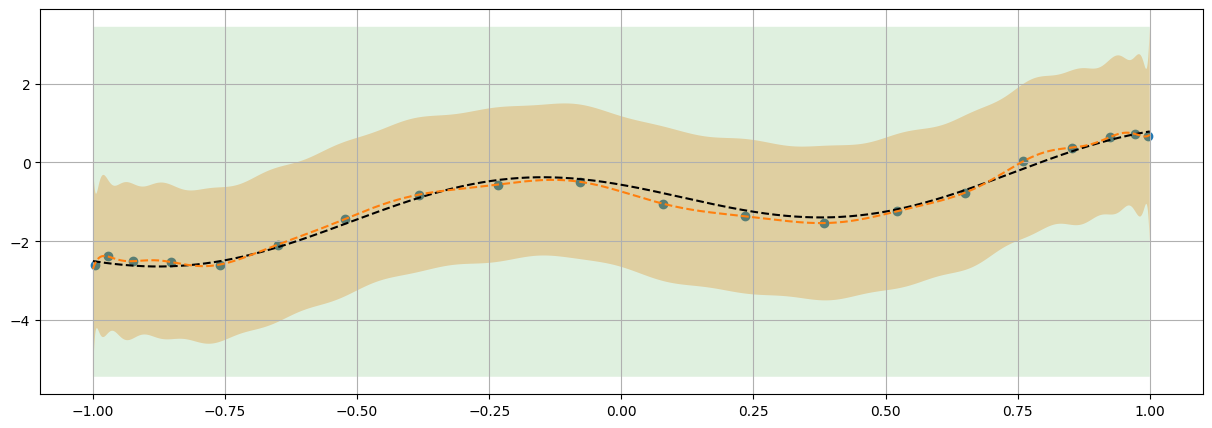

In [251]:
k=19
nodes = np.cos(np.pi * (2*np.arange(1, k+2) - 1 ) / (2*(k + 1)))
#nodes = np.linspace(-1, 1, 10)

plt.figure(figsize=(15, 5))
pr = Performative_Regression(nodes=nodes, sigma=1, n=400)
plt.scatter(pr.nodes, pr.observations(pr.nodes))
pr.plot_f_vs_g()
plt.grid()
plt.show()



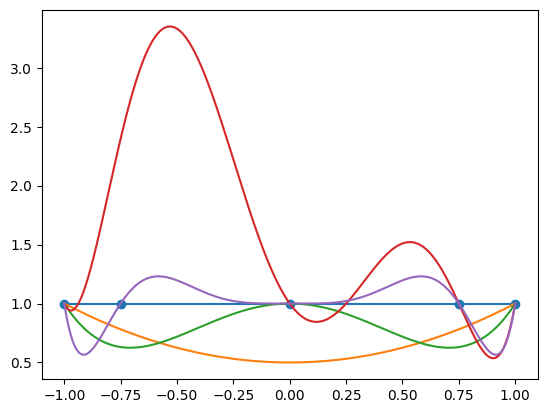

In [252]:
def lagrange_square_sum(x, nodes):

    n = len(nodes)
    if n == 1:
        return x**0 * 1
    l_sum = 0
    for i in range(n):
        prod = 1
        for j in range(n):
            if j!= i: 
                prod = prod * (x - nodes[j]) / (nodes[i] - nodes[j])

        l_sum = l_sum + prod**2

    return l_sum

t = np.linspace(-1, 1, 1000)
nodes = np.array([-1, 1, 0.0, 0.75, -0.75])
plt.scatter(nodes, np.ones(len(nodes)))
for i in range(len(nodes)):
    plt.plot(t, lagrange_square_sum(t, nodes[0:i+1]))



plt.show()